In [1]:
from tqdm.auto import tqdm
import torch 
import transformers
from transformers import PreTrainedTokenizer
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForSequenceClassification
#from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses, util
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
#import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
#from torch.nn import CosineEmbeddingLoss
import random
#from torch.nn import CosineEmbeddingLoss
from torch import nn
#Build up to SBERT model 

[2024-01-24 20:47:48,913] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
#import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/itunesGTsubsetDescriptions.tsv", sep="\t") 

In [12]:
#we're predicting all zero's, try to adjust class imbalance? 
"""
classes should already be balanced here 
posClass = df[df["entInAuthor"] == True] 
negClass = df[df["entInAuthor"] == False].sample(len(posClass)) 
df = pd.concat([posClass, negClass], axis=0) 
"""

In [5]:
#we have an annoying amount of data right now, so reduce for now
df = df.sample(int(len(df) * .25))

In [6]:
df["groundTruth"] = df["entInAuthor"].astype(int) 

In [7]:
df = df.dropna() 

In [8]:
deviceNum = 1
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

In [9]:
TRAIN_FRAC = .7 
VALID_FRAC = .1
TEST_FRAC = .2

#put ground truth values into a list 
leanDf = df[["entSnippets", "groundTruth"]] 

#reset index so it is contiguous set of numbers 
leanDf = leanDf.reset_index(drop=True)

#get train, valid, test 
trainDf, testDf = train_test_split(leanDf, test_size=0.3) 
validDf, testDf = train_test_split(testDf, test_size=0.666) 

trainDataset = Dataset.from_pandas(trainDf)
validDataset = Dataset.from_pandas(validDf)
testDataset = Dataset.from_pandas(testDf) 

In [10]:
#TODO: figure out by tokenizer isn't padding out to max_length 

In [11]:
# Preprocessing
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', max_length=512, padding="max_length", truncation=True)

In [12]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['entSnippets'], padding = "max_length", truncation=True)

trainDataset = trainDataset.map(tokenization, batched = True, batch_size = 20)
validDataset = validDataset.map(tokenization, batched = True, batch_size = 20)
testDataset = testDataset.map(tokenization, batched = True, batch_size = 20)

Map:   0%|          | 0/75788 [00:00<?, ? examples/s]

Map:   0%|          | 0/10848 [00:00<?, ? examples/s]

Map:   0%|          | 0/21633 [00:00<?, ? examples/s]

In [13]:
trainDataset.set_format(type='torch', columns=["groundTruth", "input_ids", "attention_mask"])
validDataset.set_format(type='torch', columns=["groundTruth", "input_ids", "attention_mask"])

In [14]:
#sanity check 
print(trainDf.shape) 
print(validDf.shape) 
print(testDf.shape) 
print(leanDf.shape) 

(75788, 2)
(10848, 2)
(21633, 2)
(108269, 2)


In [15]:
len(trainDataset[22]["input_ids"]) 

512

In [16]:
#model stuff
model = RobertaForSequenceClassification.from_pretrained('roberta-base').to(device) 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
#peek at config
#dropout might be the only thing we really want to look into here 
#configuration 

In [34]:
BATCH_SIZE=10
EPOCHS=1

# initialize everything
# and setup a warmup for the first ~10% steps
optim = torch.optim.Adam(model.parameters(), lr=2e-6)
total_steps = int(len(trainDataset) / BATCH_SIZE)*EPOCHS
warmup_steps = int(0.05 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)
loss_func = torch.nn.CrossEntropyLoss()

#sanity check 
print(total_steps * BATCH_SIZE)
print(trainDf.shape) 

75780
(75788, 2)


In [35]:
total_steps

7578

In [36]:
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = torch.utils.data.DataLoader(validDataset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
#validation function 
def validate(model, validLoader, loss_func):
    model.eval()
    
    outList = [[], []]
    for batch in tqdm(validLoader): 
        
        input_ids = batch["input_ids"].to(device) 
        attention_mask = batch["attention_mask"].to(device) 
        output = model(input_ids, attention_mask=attention_mask)
        normedOutputs = nn.functional.softmax(output.logits)
        preds = normedOutputs.argmax(dim=1)
        
        gt = batch["groundTruth"].to(device)
        
        #print(f"preds\n{preds}") 
        #cross entropy loss
        loss = loss_func(normedOutputs, gt)
        
        outList[0] += preds.detach().cpu().tolist()
        outList[1] += gt.detach().cpu().tolist() 
        
    f1 = f1_score(outList[0], outList[1]) 
    print(f1)
    model.train()
    return f1

In [38]:
lossList = []
validateList = []
for epoch in range(EPOCHS):
    print("EPOCH: " + str(epoch))
    #validateBi(model, validLoader, loss_func)
    
    model.train()  # make sure model is in training mode

    #DEBUGGING
    i = 0 
    currLossList = []
    for batch in tqdm(trainLoader):
        optim.zero_grad()
        
        input_ids = batch["input_ids"].to(device) 
        attention_mask = batch["attention_mask"].to(device) 
        output = model(input_ids, attention_mask=attention_mask)
        normedOutputs = nn.functional.softmax(output.logits) 
        #preds = normedOutputs.argmax(dim=1) 
        
        gt = batch["groundTruth"].to(device)
        loss = loss_func(normedOutputs, gt)
        
        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        scheduler.step()
        
        if i % 150 == 0: 
            #for train loss
            curLossList = []
            lossList.append([i, np.mean(currLossList)])
            
            #for validation stuff
            validateList.append([i, validate(model, validLoader, loss_func)]) 
            model.train() 
            print(scheduler.get_lr()) 
            
        currLossList.append(loss.item()) 
        i += 1
        
        #DEBUGGING
        """
        print(loss)
        print(scheduler.get_last_lr())
        
        #see if model params have changed
        param = list(model.parameters())[0].clone()
        print(torch.equal(param.data, prevParam.data))
        """


EPOCH: 0


  0%|          | 0/7579 [00:00<?, ?it/s]

<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)
/opt/anaconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.11450008155276464
[5.29100529100529e-09]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.5861136158701533
[7.989417989417989e-07]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.690062231346635
[1.5925925925925925e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.6881971033793908
[1.9785986514218706e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7324926639701801
[1.934623277631193e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7404833359658822
[1.8906479038405158e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7427854454203263
[1.8466725300498387e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7470263025632434
[1.8026971562591616e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7481462541549475
[1.7587217824684842e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7597035147844106
[1.714746408677807e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7635237111764238
[1.6707710348871297e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7529018642279283
[1.6267956610964526e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7613861386138614
[1.5828202873057754e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7617125073597444
[1.538844913515098e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7643043734726553
[1.494869539724421e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7640865830034532
[1.4508941659337438e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


0.7659320006834103
[1.4069187921430664e-06]


<ipython-input-38-5a3aca86abd1>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


  0%|          | 0/1085 [00:00<?, ?it/s]

<ipython-input-37-403a2a615b9c>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)


KeyboardInterrupt: 

In [39]:
lossDf = pd.DataFrame(lossList, columns=["iter", "loss"]) 

In [40]:
validDf = pd.DataFrame(validateList, columns=["iter", "f1"]) 

In [41]:
resultsDf = pd.merge(lossDf, validDf, on="iter", how="inner") 

Text(0.5, 0.98, 'Predicting Hosts in Description Snippets Surrounding Named Entities')

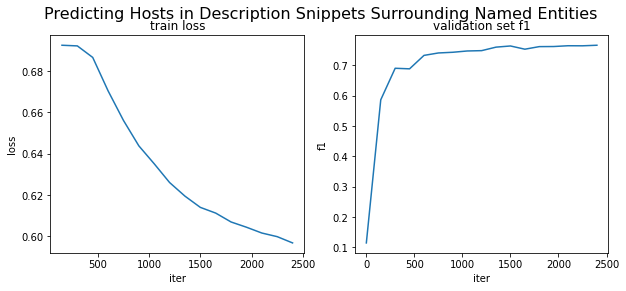

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 
sns.lineplot(data=resultsDf, x="iter", y="loss", ax=axs[0])
sns.lineplot(data=resultsDf, x="iter", y="f1", ax=axs[1])
axs[0].set_title("train loss") 
axs[1].set_title("validation set f1") 
fig.suptitle("Predicting Hosts in Description Snippets Surrounding Named Entities", size=16) 

In [192]:
loss_func(normedOutputs, gt).item() 

0.6968264579772949

In [152]:
model = model.to(device) 

In [166]:
output = model(input_ids, attention_mask=attention_masks)
normedOutputs = nn.functional.softmax(output.logits) 
preds = normedOutputs.argmax(dim=1) 

<ipython-input-166-2fd2f66a40ba>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)
